In [1]:
# Check nvcc version
!nvcc -V
# Check GCC version
!gcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2019 NVIDIA Corporation
Built on Wed_Oct_23_19:24:38_PDT_2019
Cuda compilation tools, release 10.2, V10.2.89
gcc (Ubuntu 7.5.0-3ubuntu1~18.04) 7.5.0
Copyright (C) 2017 Free Software Foundation, Inc.
This is free software; see the source for copying conditions.  There is NO
warranty; not even for MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.



In [2]:
# Install MMCV and MMDetection using MIM.
!pip3 install -U openmim
!mim install mmcv-full
!mim install mmdet

/home/salman/anaconda3/envs/mmlab/lib/python3.7/site-packages/_distutils_hack/__init__.py:30: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")
Looking in links: https://download.openmmlab.com/mmcv/dist/cu101/torch1.7.0/index.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 793.0/793.0 kB 9.2 MB/s eta 0:00:0000:01
  Preparing metadata (setup.py) ... done
Saved /tmp/tmptbb1d6gp/mmdet-2.25.0.tar.gz
Successfully downloaded mmdet
Get 'mim' extra requirements from `mminstall.txt` for mmdet 2.25.0: ['mmcv-full>=1.3.17'].
/home/salman/anaconda3/envs/mmlab/lib/python3.7/site-packages/_distutils_hack/__init__.py:30: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")
Looking in links: https://download.openmmlab.com/mmcv/dist/cu101/torch1.7.0/index.html
Using cached `mminstall.txt` for mmdet==2.25.0: /home/salman/.cache/mim/mminstall/mmdet==2.25.0.txt
Get 'mim' extra requirements from `mminstal

In [3]:
from mmcv import collect_env
collect_env()

# Check MMRotate installation
import mmrotate
print(mmrotate.__version__)

# Check MMDetection installation
import mmdet
print(mmdet.__version__)

# Check mmcv installation
from mmcv.ops import get_compiling_cuda_version, get_compiler_version
print(get_compiling_cuda_version())
print(get_compiler_version())

0.3.2
2.25.0
10.2
GCC 7.5


In [4]:
import mmcv
from mmcv.runner import load_checkpoint

from mmdet.apis import inference_detector, show_result_pyplot
from mmrotate.models import build_detector

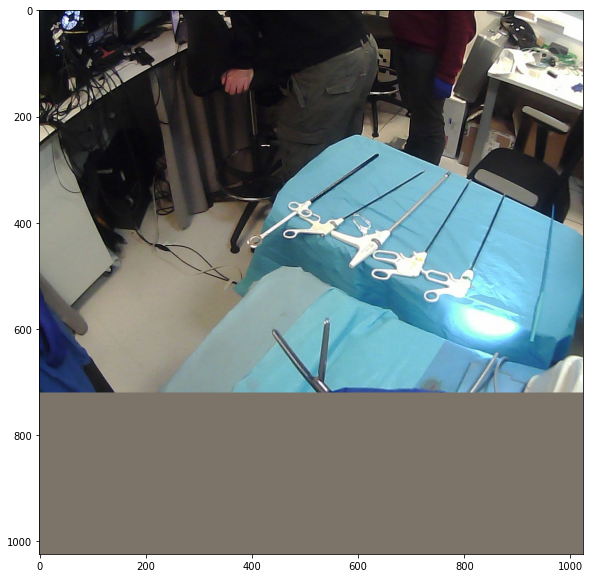

In [5]:
# Let's take a look at the dataset image
import matplotlib.pyplot as plt
img = mmcv.imread('/mnt/mars-beta/tochukwu/maestro/maestro_code/mmrotate/data/split_dota/train/images/Frame_1__1024__0___0.png')
plt.figure(figsize=(15, 10))
plt.imshow(mmcv.bgr2rgb(img))
plt.show()

In [6]:
from mmrotate.datasets.builder import ROTATED_DATASETS
from mmrotate.datasets.dota import DOTADataset


@ROTATED_DATASETS.register_module()
class BodyCam(DOTADataset):
    """SAR ship dataset for detection."""
    CLASSES = ('Clipper', 'Crocodilegrasper', 'HookDiathermy', 'Marylandgrasper', 'Scissors', 'SurgicalInstrument', 'Trocar', 'Yohangrasper',)

In [7]:
from mmcv import Config
cfg = Config.fromfile('/mnt/mars-beta/tochukwu/maestro/maestro_code/mmrotate/configs/oriented_rcnn/oriented_rcnn_r50_fpn_1x_dota_le90.py')

In [8]:
from mmdet.apis import set_random_seed

# Modify dataset type and path
cfg.dataset_type = 'BodyCam'
cfg.data_root = '/mnt/mars-beta/tochukwu/maestro/maestro_code/mmrotate/data/split_dota/'

cfg.data.test.type = 'BodyCam'
cfg.data.test.data_root = '/mnt/mars-beta/tochukwu/maestro/maestro_code/mmrotate/data/split_dota/'
cfg.data.test.ann_file = 'annfiles'
cfg.data.test.img_prefix = 'images'

cfg.data.train.type = 'BodyCam'
cfg.data.train.data_root = '/mnt/mars-beta/tochukwu/maestro/maestro_code/mmrotate/data/split_dota/'
cfg.data.train.ann_file = 'annfiles'
cfg.data.train.img_prefix = 'images'

cfg.data.val.type = 'TinyDataset'
cfg.data.val.data_root = '/mnt/mars-beta/tochukwu/maestro/maestro_code/mmrotate/data/split_dota/'
cfg.data.val.ann_file = 'annfiles'
cfg.data.val.img_prefix = 'images'

# modify num classes of the model in box head
cfg.model.roi_head.bbox_head.num_classes = 8
# We can still use the pre-trained Mask RCNN model though we do not need to
# use the mask branch
cfg.load_from = 'oriented_rcnn_r50_fpn_1x_dota_le90-6d2b2ce0.pth'

# Set up working dir to save files and logs.
cfg.work_dir = './tutorial_exps'

cfg.optimizer.lr = 0.001
cfg.lr_config.warmup = None
cfg.runner.max_epochs = 3
cfg.log_config.interval = 10

# Change the evaluation metric since we use customized dataset.
cfg.evaluation.metric = 'mAP'
# We can set the evaluation interval to reduce the evaluation times
cfg.evaluation.interval = 3
# We can set the checkpoint saving interval to reduce the storage cost
cfg.checkpoint_config.interval = 3

# Set seed thus the results are more reproducible
cfg.seed = 0
set_random_seed(0, deterministic=False)
cfg.gpu_ids = range(1)
cfg.device='cuda'

# We can also use tensorboard to log the training process
cfg.log_config.hooks = [
    dict(type='TextLoggerHook'),
    dict(type='TensorboardLoggerHook')]


# We can initialize the logger for training and have a look
# at the final config used for training
print(f'Config:\n{cfg.pretty_text}')

Config:
dataset_type = 'BodyCam'
data_root = '/mnt/mars-beta/tochukwu/maestro/maestro_code/mmrotate/data/split_dota/'
img_norm_cfg = dict(
    mean=[123.675, 116.28, 103.53], std=[58.395, 57.12, 57.375], to_rgb=True)
train_pipeline = [
    dict(type='LoadImageFromFile'),
    dict(type='LoadAnnotations', with_bbox=True),
    dict(type='RResize', img_scale=(1024, 1024)),
    dict(
        type='RRandomFlip',
        flip_ratio=[0.25, 0.25, 0.25],
        direction=['horizontal', 'vertical', 'diagonal'],
        version='le90'),
    dict(
        type='Normalize',
        mean=[123.675, 116.28, 103.53],
        std=[58.395, 57.12, 57.375],
        to_rgb=True),
    dict(type='Pad', size_divisor=32),
    dict(type='DefaultFormatBundle'),
    dict(type='Collect', keys=['img', 'gt_bboxes', 'gt_labels'])
]
test_pipeline = [
    dict(type='LoadImageFromFile'),
    dict(
        type='MultiScaleFlipAug',
        img_scale=(1024, 1024),
        flip=False,
        transforms=[
            dict(t